<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/multi_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 20 18:08:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import time
import dlib, cv2
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch import nn

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
!echo '3FDsALdx4sLyMedGxO5h:RsdZX1E2jRryINc6Vb5HGpL1FY84lNBXbTNSU8Ln' > ~/.passwd-s3fs
!cat ~/.passwd-s3fs
!chmod 600 ~/.passwd-s3fs
!mkdir /s3
!apt install s3fs
!s3fs w251-final-project /s3 -o passwd_file=~/.passwd-s3fs,url=https://s3.us.cloud-object-storage.appdomain.cloud

3FDsALdx4sLyMedGxO5h:RsdZX1E2jRryINc6Vb5HGpL1FY84lNBXbTNSU8Ln
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 200 kB of archives.
After this operation, 557 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 s3fs amd64 1.82-1 [200 kB]
Fetched 200 kB in 1s (319 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.82-1_amd64.deb ...
Unpacking s3fs (1.82-1) ...
Setting up s3fs (1.82-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [9]:
!pip3 install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=d3a4cd55525265ae12c22491cb54dffedc8629987dd34e36332509c10c257a84
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [10]:
import face_recognition

In [11]:
!cp /s3/retinaface.py .

In [12]:
from retinaface import create_retinaface, get_detections

In [13]:
return_layers = {'layer2':1,'layer3':2,'layer4':3}
RetinaFace = create_retinaface(return_layers)

retina_dict = RetinaFace.state_dict()
pre_state_dict = torch.load("/s3/pretrained_weights/model.pt", map_location=torch.device(device))
pretrained_dict = {k[7:]: v for k, v in pre_state_dict.items() if k[7:] in retina_dict}
RetinaFace.load_state_dict(pretrained_dict)

RetinaFace = RetinaFace.to(device)
RetinaFace.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [17]:
frames_per_video = 8
crop_size = 256
MAX_CROP_TIME = 30
def retina_scan_multi(RetinaFace, vid_path, num_images=frames_per_video):

    cap = cv2.VideoCapture(vid_path)
    count = 0

    encodings = []
    crops = []
    vid_name = vid_path.split('/')[-1].split('.')[0]
    
    t0 = time.time()
    unk = -1
    #print("working: ",end='')
    while (True):
        if int(time.time() - t0) > MAX_CROP_TIME:
            print("Max time exceeded")
            break
        if count >= num_images:
            break
        ret, img = cap.read()
        if not ret:
            #print(' done!')           
            break

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img)
        img = img.permute(2,0,1)

        input_img = img.unsqueeze(0).float().to(device)

        picked_boxes, _, picked_scores = get_detections(input_img, RetinaFace, score_threshold=0.5, iou_threshold=0.3)

        np_img = img.cpu().permute(1,2,0).numpy()
        np_img.astype(int)
        img = np_img.astype(np.uint8)

        for j, boxes in enumerate(picked_boxes):
            if boxes is not None:
                for box, score in zip(boxes,picked_scores[j]):
                    if score > 0.9:
                        count += 1
                        bxs = list(box.cpu().numpy().astype(np.int32).ravel())
                        h = bxs[3] - bxs[1]
                        my = max((crop_size - h), 0)//2
                        w = bxs[2] - bxs[0]
                        mw = max((crop_size - w), 0)//2
                        y1 = max(bxs[1] - my, 0)
                        y2 = min(bxs[3] + my, img.shape[0])
                        x1 = max(bxs[0] - mw, 0)
                        x2 = min(bxs[2] + mw, img.shape[1])
                        crop = img[y1:y2,x1:x2,:]
                        if crop.shape[0] == 0 or crop.shape[1] == 0:
                            continue
                        crop = cv2.resize(crop, (crop_size, crop_size), interpolation=cv2.INTER_AREA)
                        enc = face_recognition.face_encodings(crop)
                        if len(enc) != 0:
                            res = face_recognition.compare_faces(encodings, enc[0])
                            if len(res) != 0:
                                for i, r in enumerate(res):
                                    if r:
                                        crops[i].append(crop)
                                        break
                            else:
                                spot = len(encodings)
                                crops.append([crop])
                                encodings.append(enc[0])
                        else:
                            if unk == -1:
                                unk = len(encodings)
                                crops.append([crop])
                            else:
                                crops[unk].append(crop) 
                        #print("!",end='')

    cap.release()

    return crops

In [18]:
scans = retina_scan_multi(RetinaFace, '/s3/DFDC/dfdc_train_part_0/gcdtglsoqj.mp4', 20)

In [19]:
len(scans),len(scans[0]),len(scans[1])

(2, 10, 10)

In [20]:
scans[1][1].shape

(256, 256, 3)

In [22]:
import matplotlib.pyplot as plt

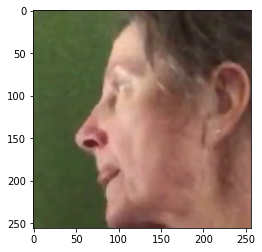

In [24]:
plt.imshow(scans[1][6])

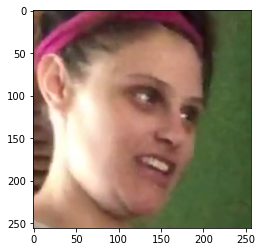

In [25]:
plt.imshow(scans[0][6])